<div align="right">Python 2.7 Jupyter Notebook</div>

# Exploring noise vs. bias

### Your completion of the notebook exercises will be graded based on your ability to do the following: 

> **Analyze**: Are you able to pick the relevant method or library to resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

#### Notebook objectives
By the end of this notebook, you will be expected to:
> - Have a basic understanding of the concept of a distribution;
- Use the shape of a distribution, and distribution parameters to distinguish between bias and noise; an
- Use the Python Imaging Library.
 
####  List of exercises
>   - **Exercise 1**: Reducing the effect of bias in data.
  - **Exercise 2**: Understanding the effect of increasing sample size on the shape of noisy and biased data.

# 1. Notebook introduction

This notebook compares noise and bias through a practical demonstration, as discussed by Arek Stopczynski in the Module 3 video content. A data set will be generated, and you will build on your understanding of how to create functions that can be reused. All examples demonstrated in the previous notebooks were created manually, or were based on external libraries and the functions contained therein. You will likely have specific patterns of execution, that you typically repeat frequently,  which either do not exist, or are unknown to you. This can be done in the notebook itself or you can start to create libraries of functions that you refer to between projects or even between different individuals.

In order to demonstrate the principles of noise and bias, a set of functions will be used to create random points on the supplied image. Following this, an example will continue to demonstrate the difference between noise and bias.

This notebook will make use of a new Python library called the [Python Imaging Library](http://www.pythonware.com/products/pil/) (PIL). It is first used in the first section of this notebook, and then later in the notebook (in a brief deviation from the course content) to demonstrate how to manipulate images.

> **Note**:

> Students who may not be familiar with the advanced technical content should read the “Create functions” subsection for a logical description of steps, and should not be concerned if the code and syntax do not make sense. The code is included to demonstrate the principles. Advanced students will also benefit from having the example code accessible.

<div class="alert alert-warning">
<b>Note</b>:<br>
It is strongly recommended that you save and checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.
</div>

#### Load libraries and set options

In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import random
import copy
import numpy as np
import operator

# Set plotting options.
%matplotlib inline

# 1 Exploring bias and noise in data

Bias and noise errors are to be expected in data collected in experiments. Therefore, one of the critical skills you will be using in data analysis is the identification and estimation of these errors. In this example, you will explore how to understand these errors, using a simulation of GPS measurements observed on a student population during an experiment that was alluded to by Arek Stopczynski in the video content. The aim of the experiment was to estimate the time they spend indoors and outdoors.
> **Note**: 

>Read the comments that precede the function descriptions, and ensure you understand the difference between noise and bias, before completing the exercises that follow.

### 1.1 Create functions
In order to demonstrate the difference between noise and bias, a number of functions will be created.

In [2]:
# Check if the point is inside a building based on the color of the point on the image.
def is_point_inside_building(x, y, pix, im, s=5):
    building_color = (244, 243, 236, 255)
    
    is_inside = False
    
    for v_x in range(max(x-s,0),min(x+s,im.size[0])):
        for v_y in range(max(y-s,0),min(y+s,im.size[1])):
            if pix[v_x, v_y] == building_color:
                is_inside = True
    return is_inside

# Add the markers to the map.
def put_points_on_map(points, pix, im, point_size=5):
    for point in points:
        put_point_on_map(point[0],point[1],point[2],pix,im)    

# Set the color of the point based on whether the point is inside or outside the building. (Inside = Red, Outside = Blue)
def put_point_on_map(x, y, is_inside, pix, im, point_size=5):
    for v_x in range(max(x-point_size,0),min(x+point_size,im.size[0])):
        for v_y in range(max(y-point_size,0),min(y+point_size,im.size[1])):
            if is_inside: 
                pix[v_x,v_y] = (255, 0, 0)
            else:
                pix[v_x,v_y] = (0, 0, 255)
                
# Generate random points to be added to our image using the randint from the random library.
# https://docs.python.org/2/library/random.html
def generate_random_points(pix,im, n=200, threshold=0.5):
    points = set()
    n_inside = 0
    
    while len(points) < n:
        x = random.randint(0,im.size[0])
        y = random.randint(0,im.size[1])
        is_inside = is_point_inside_building(x, y, pix, im)
        
        if len(points) > 0: 
            n_inside = len([v for v in points if v[2] == True])/float(len(points))
 
        if n_inside < threshold and not is_inside: 
            continue               
        #print is_inside
        points.add((x,y,is_inside))
        
    return points

# Calculate the time spent inside by using number of observations as a proxy for actual time.
def calculate_time_inside(points):
    return len([v for v in points if v[2] == True])/float(len(points))

# Set plotting options and plot the diagram using Matplotlib.
def plot_map(points, im, pix, s, point_size=5):
    put_points_on_map(points, pix, im)
    f = plt.figure()
    plt.imshow(im)
    plt.title(s)
    f.set_size_inches(18.5, 10.5)

# Create a new points list where we introduce random errors using shuffle from the random library.
# https://docs.python.org/2/library/random.html
def introduce_random_error(points, error=0.4):
    points_list = list(points)
    random.shuffle(points_list)
    return set(points_list[:int(len(points_list)*error)])

# Calculate the random error using the previously created function.
def calculate_random_error(points, error=0.4, k=100):
    xx = []
    for i in range(k):
        points_copy = copy.deepcopy(points)
        points_copy = introduce_random_error(points_copy, error=error)
        xx.append(calculate_time_inside(points_copy))
    plot_results(xx, 'Histogram with random errors.')
    return points_copy

# Calculate bias using our previously created function.
def calculate_bias(points, error=0.4, bias=0.7, k=100):
    xx = []
    for i in range(k):
        points_copy = copy.deepcopy(points)
        points_copy = introduce_bias(points_copy, error=error, bias=bias)
        xx.append(calculate_time_inside(points_copy))
    plot_results(xx, 'Histogram with bias.')
    return points_copy

# Produce plots using our previously created function. 
# We print the mean and standard deviation using NumPy functions.
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html  
def plot_results(xx, s = 'Histogram'):
    plt.figure()
    plt.hist(xx)    
    plt.axvline(np.mean(xx), color='r', linestyle='dashed', linewidth=2)
    plt.title(s)
    print 'mean = {}, std = {}.'.format(np.mean(xx), np.std(xx))
    
# Create a new points list where we introduce bias using choice and random from the random library.
# https://docs.python.org/2/library/random.html
def introduce_bias(points, error=0.4, bias=0.7):
    new_points = copy.deepcopy(points)
    while len(new_points) > int(len(points)*error):
        point = random.choice([v for v in new_points])
        is_inside = point[2]
        if is_inside:
            if random.random() < bias:
                new_points.remove(point)
        if not is_inside:
            if random.random() > bias:
                new_points.remove(point)
        
    return new_points

### 2.2 The shape of data
Before demonstrating the concept of bias and variance (noise), it is instructive to introduce some basic statistical concepts used to describe data. In statistics, a distribution is used to capture the notion of the shape of a data set or variable. Formally, a distribution is a description of the relative number of times each possible outcome will occur in a number of trials. There exist a number of statistical distributions, which are expressed using a mathematical equation that describes the shape, for describing a data set's underlying generating mechanism. The most common of these is the [normal distribution](http://mathworld.wolfram.com/NormalDistribution.html) that is described by a bell curve shape. Comparing statistical estimates from an observed data set fitted to some assumed distribution is an important technique that helps to detect abnormal trends and occurrences in the data. Visualization of the data helps to reveal the deviation of data from a trend, or detect anomalous patterns in a set of data.

The normal distribution referred to above is used to describe data that tends to cluster around a central value, with no bias for values to the left or right of the central value. In other words, 50% of the values occur below the central value, and 50% above the central value. The central value is referred to as the *mean* or *average*. In Module 1, you may recall the following example that used normal distribution to generate and plot IQ data in a histogram.


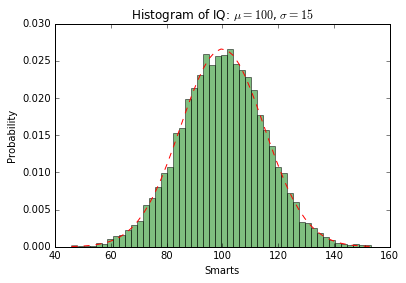

In [3]:
# Example data.
mu = 100  # Mean of distribution.
sigma = 15  # Standard deviation of distribution.
x = mu + sigma * np.random.randn(10000)

num_bins = 50
# The histogram of the data.
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
# Add a 'best fit' line.
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

In the IQ data example that was just plotted, the data has a central tendency (or **mean** $\mu$) towards the value 100, and a standard deviation of $\sigma$ of 15. The value for standard deviation defines a range above and below the mean for which a certain percentage of the data lies, or how spread out the data is. It is a useful parameter because you can make the following probability assertions about any value drawn from the normal distribution:
- It is likely within 1 standard deviation ($\mu \pm \sigma$) = 68%.
- It is very likely within 2 standard deviations ($\mu \pm 2\sigma$) = 95%.
- It is almost certainly within 3 standard deviations ($\mu \pm 3\sigma$) = 99.7%.

### 1.3 Demonstration

#### 1.3.1 Validate the data set
The image objects and their properties are created before generating the random points. Before moving on, a manual review of the generated data is performed to validate that the time spent inside is as expected.

In [4]:
# Create image object and load properties to a variable using the image library from PIL.
# Base image. 
im_org = Image.open("dtu_map.png")
pix_org = im_org.load()

# Random error example.
im_random_error = Image.open("dtu_map.png")
pix_random_error = im_random_error.load()

# Bias example.
im_bias = Image.open("dtu_map.png")
pix_bias = im_bias.load()

## Generate random points.
# The function that we created previously accepts the image, its properties, number of points and a threshold for points inside as parameters.
points = generate_random_points(pix_org, im_org, n=500, threshold=0.6)

## Calculate and print the time spent inside.
print 'Proportion of time spent inside (based on number of observations): {}.'.format(calculate_time_inside(points))

Proportion of time spent inside (based on number of observations): 0.6.


#### 1.3.2 Plot the map of observations, using one of the functions created earlier
In the plot below, the red corresponds to inside locations, while the blue dots corresponds to outside locations.

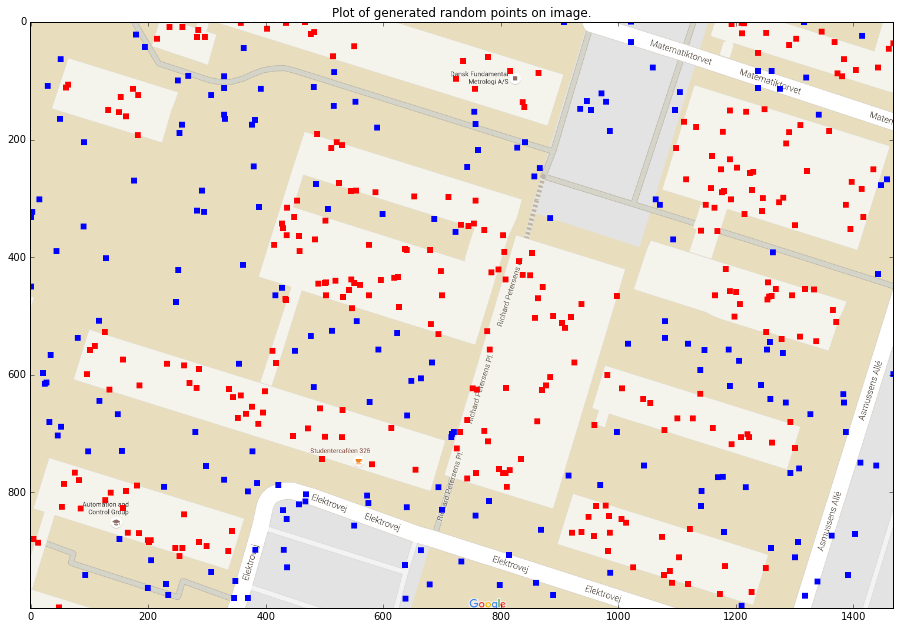

In [5]:
# Plot the generated dataset.
plot_map(points, im_org, pix_org, 'Plot of generated random points on image.')

#### 1.3.3 Noise or random errors
In the video content, Arek Stopczynski indicates that noise can be countered by collecting more data, because the average or mean is centered around the true value. This can be visualized using the functions created earlier. Histograms are convenient plotting mechanisms for demonstrating this behavior. The mean and standard deviation are also produced as outputs of this function, which will allow you to plot a new map to show the updated result set.

mean = 0.599715, std = 0.0265865337154.


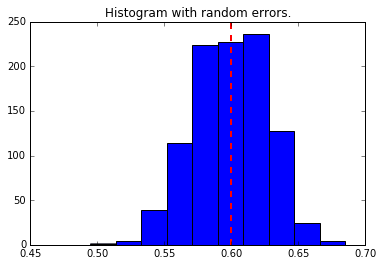

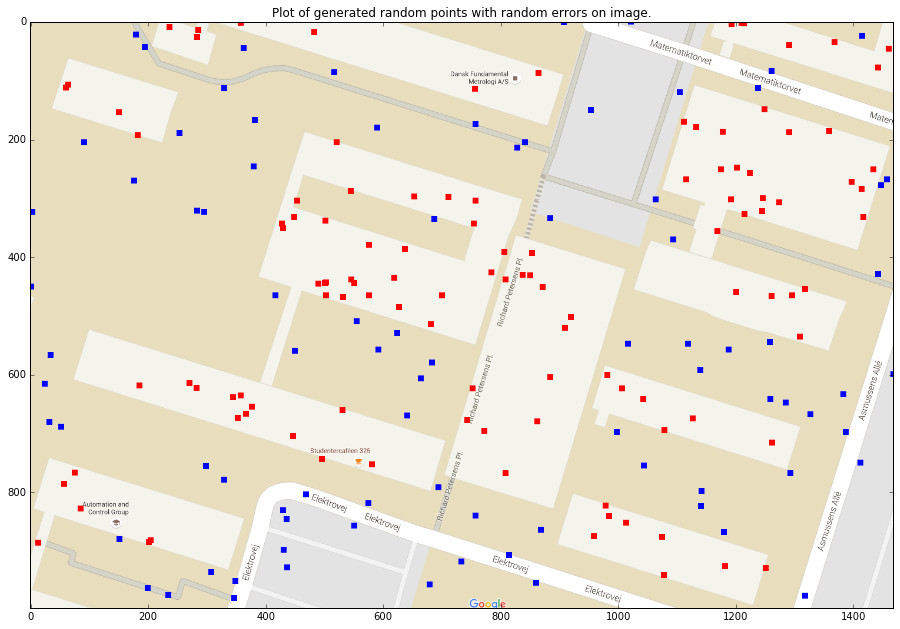

In [6]:
# Demonstrate random error.
random_error_points = calculate_random_error(points, k=1000)
plot_map(random_error_points, im_random_error, pix_random_error, 'Plot of generated random points with random errors on image.')

#### 1.3.4 Bias or systematic errors
When there are systematic errors (bias) present in your data set, you will need to employ alternative methods to clean your data. Take note of the shift in the histogram where it is no longer centered around the mean. As per the previous example, the mean and standard deviation are produced, as well as the updated map.

mean = 0.511945, std = 0.0274033205105.


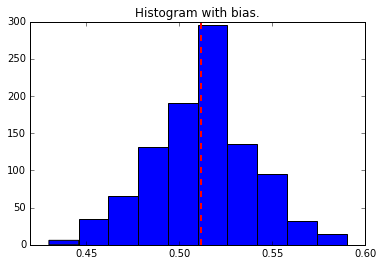

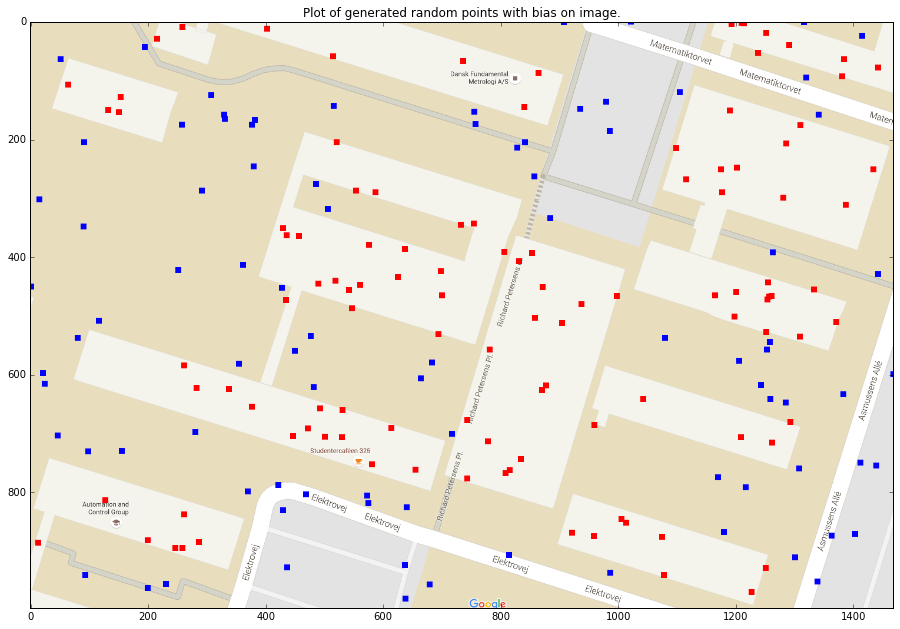

In [7]:
# Demonstrate bias.
bias_points = calculate_bias(points, k=1000, bias=0.6)
plot_map(bias_points, im_bias, pix_bias, 'Plot of generated random points with bias on image.')

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Assume that the "outside" data points in the previous example are accurate. How would you clean the "bias_points" if this were the only data set you had?

> **Note**: 

> Provide a written, logical answer. You do not need to perform any calculations for grading purposes.

Your markdown answer.

### How would I clean the "bias_points" if the "outside" data points are accurate, and the only data set I had?
>#### 1. I could normalise the data by applying a correction factor, such as the probability of GPS failure inside a building vs outside a building.
>#### 2. I could apply more agressive 'smoothing' such as the assumption that a block of missing data (after a person enters a building) means the person IS inside the building.
>#### 3. For downstream statistical analysis, it is common practice to 'normalise' data by transforming the raw data using log values, first-order differencing, etc.. so that the data better fits the Central Limit Theorem.


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 Start.</b>
</div>

### Instructions
> Plot what happens with the estimated values of the mean and  standard deviation when you increase the number of datapoints in:

> 1. Noisy data; and 

> 2. Biased data.

> **Hint**:

>Try using values of 1000 and 10000 for $k$ in each case. You will need to make use of the following functions, and change the value of $k$ as indicated:
- `calculate_random_error()`
- `calculate_bias()`

In [ ]:
# Your solution here

### 1. Increasing the number of data points in Noisy data:

mean = 0.60041, std = 0.0284549099454.


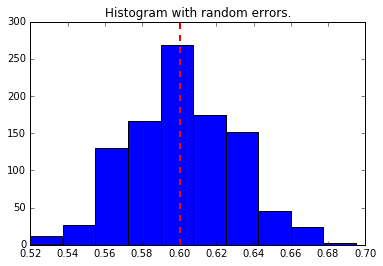

In [9]:
# Generate random numbers for k=1000
# Plot the estimated mean and std
random_error_points = calculate_random_error(points, k=1000)
#plot_map(random_error_points, im_random_error, pix_random_error, 'Plot of generated random points with random errors on image.')

mean = 0.599483, std = 0.026935435972.


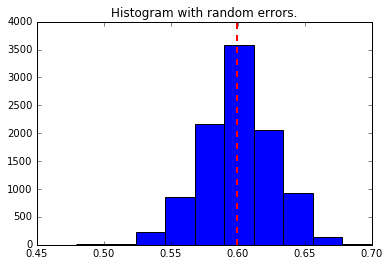

In [10]:
# Generate random numbers for k=10000
# Plot the estimated mean and std
random_error_points = calculate_random_error(points, k=10000)

### Observations:
> #### 1. Increasing the data points 10-fold has improved the std slightly (0.028 to 0.026)
> #### 2. Both the k=1000 and k-10000 distributions are closely around a true mean value (~0.60)
> #### 3. Increasing data points can improve on data quality when there are random (noise) errors

### 2. Increasing the number of data points in Biased data

In [ ]:
# Generate random numbers for k=1000, and bias of 0.5
# Plot the estimated mean and std

mean = 0.60103, std = 0.0270025758031.


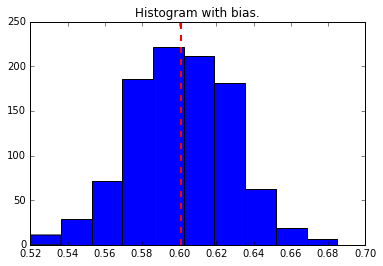

In [15]:
bias_points = calculate_bias(points, k=1000, bias=0.5)

mean = 0.781795, std = 0.0250540011775.


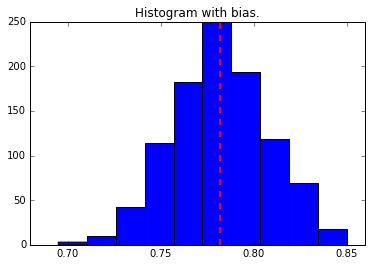

In [16]:
# Now I test generating random numbers for k=1000, and bias of 0.3
bias_points = calculate_bias(points, k=1000, bias=0.3)

mean = 0.419955, std = 0.0267296272888.


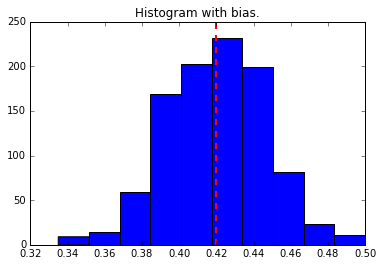

In [11]:
# Next I test generating random numbers for k=1000, and bias in the opposite direction, =0.7
bias_points = calculate_bias(points, k=1000, bias=0.7)

mean = 0.420471, std = 0.0262755239529.


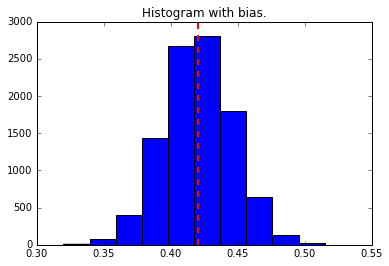

In [12]:
# Next I test generating more random numbers for k=10000, and bias = 0.7 to see if the mean is any where nearer the true value
bias_points = calculate_bias(points, k=10000, bias=0.7)

### Observations:
> #### 1. Plot of bias=0.5 indicated a good approximation of distribution around the true mean (mean = 0.60 and std = 0.27 is very similar to the previous random error plots)
> #### 2. Plot of bias=0.3 and 0.7 showed their respective means (0.78 and 0.41) have indeed shifted to either side of the true mean (0.60)
> #### 3. Increasing the number of data points 10-fold did not help to correct the systemic error, as the distribution is still around a biased mean value (0.42) that is shifted away from the true mean value (0.60)
> #### 4. Conclusion - increasing the number of data points does not gives you better quality when there is systemic (biased) error in the data!

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 2. Introduction to PIL
While you will not spend much time on this library in this course, this section of the notebook serves as a brief introduction to the Python Imaging Library, as it was utilized in the previous section. Many of you may not be aware of the wide range of potential uses of Python, and the options that exist. In the previous example, an image was used as an input file. Points were then classified as inside or outside, based on the pixel color of the randomly-generated points on the image.

You can obtain similar images from [Google maps](https://www.google.co.za/maps/place/Dansk+Fundamental+Metrologi+A%2FS/@55.7839786,12.5174761,18.5z/data=!4m5!3m4!1s0x46524e7d0398546f:0xcc373daed6ed3e95!8m2!3d55.7846082!4d12.5183756?hl=en), and perform some basic data exploration and wrangling functions. You will need to update the colors used in the functions to reflect those present in your image. It is, therefore, advised that you select a basic image with few color variations.

In the previous example it was assumed that everyone was outside, and the status was updated if the color matched a building. This is much easier than trying to account for all the possible variations in color that you may come across.

> **Note**:

> The simplistic approach applied in this trivial example **does not scale, and should not be used for image processing**. Image processing is outside of the scope of this course and requires different tools and infrastructure configurations than those that have been provisioned. Attempts to perform non-trivial operations on your virtual analysis environment may result in the depletion of the resources required to complete this course, and should be avoided.

In the following example, Python tools and libraries are used to wrangle the data. This example, therefore, starts with the question of which colors are present in the image.
1. Create a dictionary of colors.
2. Create a sorted list in order to find the most prevalent color.
3. Change the image by substituting one color for another.

While this example is by no means extensive in demonstrating the capabilities of either Python or the PIL library, the aim is to emphasize that input data does not always have to be traditional data files.

#### 2.1 Load the image again
Start by importing the same image used previously, and display some basic information about the image.

In [32]:
im = Image.open("dtu_map.png")
print('image format:{}, image size: {}, image mode: {}'.format(im.format, im.size, im.mode))

image format:PNG, image size: (1468, 997), image mode: RGBA


#### 2.2 Create a list of colors present in the image
Create a sorted list, and display the five RGBA (red green blue alpha) colors observed most frequently in reversed, sorted order.

In [33]:
# Create color dictionary.
colors = {}
for color in im.getdata():
    colors[color] = colors.get(color, 0) + 1

# Create sorted list.
sorted_c = sorted(colors.items(), key=operator.itemgetter(1), reverse=True)

# Display the first 5 records of the list.
sorted_c[:5]    

[((232, 221, 189, 255), 735549),
 ((244, 243, 236, 255), 482843),
 ((227, 227, 227, 255), 123193),
 ((255, 255, 255, 255), 48821),
 ((213, 212, 200, 255), 16077)]

#### 2.3 Substitute one color for another and display the updated image
Replace the color used to identify buildings, RGBA color (244, 243, 236, 255), in the previous example, with another, (50, 50, 255, 255). You can search for RGBA color codes and replace the second, (50, 50, 255, 255), with a color of your choice, should you wish to do so.

In [34]:
# Obtain pixel data and replace a specific color in the image with another.
pixdata = im.load()

# Change the building color.
for y in xrange(im.size[1]):
    for x in xrange(im.size[0]):
#        if pixdata[x, y] == (244, 243, 236, 255):    # check for current building color
#            pixdata[x, y] = (50, 50, 255, 255)       # replace with new color
        if pixdata[x, y] == (244, 243, 236, 255):    # check for current building color
            pixdata[x, y] = (127, 63, 191, 255)       # replace with purple colour

# The lines below have been commented out as the image is included in course material. 
# Advanced students can uncomment the relevant portions to save and display their images with alternative colors.


im.save('updated_file2.png') # Save the updated image.

im.show() # Show the updated image.

Look at the updated image:

![Updated image](updated_file.png "Image with the building color changed to blue.")

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.